### Import Package

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import copy
import time
from torch.nn.modules.batchnorm import BatchNorm1d
import matplotlib.pyplot as plt
import scipy

## Estimation Score

### Define the Stucture Model

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert (
            self.head_dim * heads == embed_dim
        ), "Embedding dimension needs to be divisible by heads"

        self.values_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries_linear = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_dim)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values_linear(values)
        keys = self.keys_linear(keys)
        queries = self.queries_linear(query)

        # Get the dot product between queries and keys, and then apply the softmax
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_dim ** (1 / 2)), dim=3)

        # Apply the self attention to the values
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class TimeSeriesModel(nn.Module):
    def __init__(self, embed_dim, heads, max_length,output_dim=1):
        super().__init__()
        self.self_attention = SelfAttention(embed_dim, heads)
        self.global_pooling = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(embed_dim, output_dim)
        self.pos_encoder = PositionalEncoding(embed_dim,max_length)
        self.batch_norm1 = BatchNorm1d(embed_dim,max_length)
        

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = self.self_attention(x, x, x)  # Apply self-attention
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = x.permute(0, 2, 1)  # Switch dimensions for pooling
        x = self.global_pooling(x).squeeze(2)  # Apply global pooling
        x = self.linear(x)  # Apply final linear layer
        x = x.squeeze()
        return x

### Make Dataset

#### Necessary Function

In [7]:
def ConvertTextToNumpyArray(text): # text array -> numpy array '[1,2,3]' -> [1,2,3]
    # Step 1: Remove the square brackets and extra whitespace
    text_cleaned = text.strip('[]').strip()

    # Step 2: Split the cleaned text by whitespace to get individual integers as strings
    int_strings = text_cleaned.split()


    # Step 3: Convert the strings to integers
    integers = [int(x) for x in int_strings]
    integers

    numpy_array = np.array(integers)
    return numpy_array

def ConvertRowToNumpy(a): # Row with last element is text array -> array with concatenated way [1,4,6,'[1,2,3]'] -> [1,4,6,1,2,3]
    temp = ConvertTextToNumpyArray(a[8])
    ResultedNumpy = np.concatenate((a[0:8],temp),axis=0)
    return ResultedNumpy


def ConvertDataFrameToNumpy(t): # Dataframe -> Numpy array

    # Convert DataFrame To Numpy
    original_array = t.values

    # Use np.vectorize to apply the custom function to each row in the original array
    vectorized_process = np.vectorize(ConvertRowToNumpy, signature='(m)->(n)')

    # Process the entire original array without using an explicit for loop
    final_array = vectorized_process(original_array)
    return final_array

def ConvertCSVToNumpy(CSVPath,p): # CSV Path -> Numpy array
    if os.path.isfile(CSVPath):
        t = pd.read_csv(CSVPath)
        NumpyResult = ConvertDataFrameToNumpy(t)
        return NumpyResult
    else:
        np.zeros(shape=(p,))

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence([seq for seq in sequences], batch_first=True)
    labels = torch.as_tensor(labels)
    return sequences_padded.float(), labels.float()        
        

#### Load File name and Y data File

In [8]:
RootPath = "D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel"
PathLoadExcel = os.path.join(RootPath,"VirtFuse data 26072023.xlsx")
t = pd.read_excel(PathLoadExcel)
t

,Date,file name,initial temperature,Unnamed: 3,Catalyst #1: trig93,Catalyst #2: trig524 (2%),Accelerator: cob 6% (max 0.7%),Quality score
0,2023-05-05 00:00:00,192.168.1.64_02_20230505085243583.mp4,18,18,60,420,156,7
1,2023-05-05 00:00:00,192.168.1.64_02_202305050100543584.mp4,20,20,90,390,150,5
2,2023-05-30 00:00:00,192.168.1.64_02_2023053008542479.mp4,19,20,90,390,150,6
3,2023-06-21 00:00:00,192.168.1.64_02_20230621074514667.mp4,20,20,90,390,150,8
4,2023-06-28 00:00:00,192.168.1.64_02_20230628102913672.mp4,25,26,180,300,132,3
5,2023-06-28 00:00:00,192.168.1.64_02_20230628090938483.mp4,22,22,120,360,144,4
6,29/06/2023,192.168.1.64_02_20230629110733693.mp4,27,28,210,270,126,6
7,2023-06-30 00:00:00,192.168.1.64_02_20230630141655536.mp4,30,30,240,240,120,7
8,2023-06-30 00:00:00,192.168.1.64_02_20230630125757199.mp4,30,30,240,240,120,3
9,2023-06-30 00:00:00,192.168.1.64_02_20230630110342551.mp4,27,28,210,270,126,2


In [33]:
t.values[0][8]

'[ 4475 21834 20889 94056 42856  5078  1331   999   393    89]'

#### Extract Time Series Feature From the file

In [9]:
RootPath = "D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel"
PathLoadExcel = os.path.join(RootPath,"VirtFuse data 26072023.xlsx")


t = pd.read_excel(PathLoadExcel)
# print(t)
type(t['file name'].values)

text = t['file name'].values[10]
# print(text)
def ExtractCSVName(text):
    ## Extract The file name
    temp = text.split(".")[0:-1]
    return '.'.join(temp) + '.csv'

text = ExtractCSVName(text)    
# print(text)
filePath = os.path.join(RootPath,text)


def ExtaractFilePath(RootPath,text):
    text = ExtractCSVName(text)    
    filePath = os.path.join(RootPath,text)
    return filePath


ExtaractFilePath(RootPath,text)

filePath = np.vectorize(ExtaractFilePath, excluded=[RootPath])

FilePathArray = filePath(RootPath=RootPath,text = t['file name'].values)


## Check Number OF Missing
def isFile(filePath):
    return os.path.isfile(filePath)
CheckFile = np.vectorize(isFile)
index = np.where(CheckFile(FilePathArray))
FilePathArray = FilePathArray[index]     
a = zip(FilePathArray,t['Quality score'].values[index])
dictionary = {k:v for k,v in a}
dictionary

{'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230505085243583.csv': 7,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_2023053008542479.csv': 6,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230628102913672.csv': 3,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230628090938483.csv': 4,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230629110733693.csv': 6,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230630141655536.csv': 7,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230630125757199.csv': 3,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyKlos\\Data\\DataForAIModel\\192.168.1.64_02_20230630110342551.csv': 2,
 'D:\\DoctoralSharif\\NoranCompany\\Proposal\\KyK

##### Test Filtering the non-existence files

In [10]:
def Check(index):
    text = t['file name'].values[index]
    temp = text.split(".")[0:-1]
    R = '.'.join(temp) + '.csv'
    return dictionary[os.path.join(RootPath,R)] == t['Quality score'].values[index]

T = np.vectorize(Check)

t1 = np.linspace(0,FilePathArray.shape[0]-1,FilePathArray.shape[0]).astype(int)
n = [t1[0],t1[2],t1[4]]
n = np.array(n, dtype=int)
n = np.concatenate((n,t1[5:]),axis=0,dtype=int)
n

array([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

##### Extraction Part

In [11]:
def ExtractX(CSVPath,p):
    X = ConvertCSVToNumpy(CSVPath,p)
    return X
    

VectorizedX = np.vectorize(ExtractX,excluded=['p'])    
InputFeature  = VectorizedX(CSVPath = FilePathArray,p=18)    

In [7]:
InputFeature[0].shape

(30195, 18)

##### Convert To Tensor Data 

In [12]:
XData = [torch.tensor(InputFeature[i][30:1030].astype(float)) for i in np.arange(InputFeature.shape[0])]

In [13]:
YData = torch.tensor(t['Quality score'].values[index])

##### Create Tensor Dataset

In [24]:
class VariableLengthSequenceDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.target[idx])

In [16]:
dataset = VariableLengthSequenceDataset(XData,YData)
# dataloader = DataLoader(dataset, batch_size=3)

##### Division train and test

In [17]:
data_length = len(dataset)
# train_sets, val_sets, test_sets = torch.utils.data.random_split(dataset, [np.floor(data_length*(1-test_per-val_per)).astype(int),np.floor(data_length*(val_per)).astype(int), np.ceil(data_length*(test_per)).astype(int)])
train_sets, test_sets = torch.utils.data.random_split(dataset, [int(np.ceil(0.8*data_length)), int(np.floor(0.2*data_length))])

In [18]:
len(test_sets)
dataloaders = {}
batch_size = 3

dataloaders['train'] = DataLoader(train_sets, batch_size=batch_size, collate_fn=collate_fn,
                                              shuffle=True) 

dataloaders['test'] = DataLoader(test_sets, batch_size=batch_size, collate_fn=collate_fn,
                                              shuffle=True)


dataset_sizes = {}

dataset_sizes["train"] = len(train_sets)
dataset_sizes["test"]  = len(test_sets)


In [19]:
for i, (data, target) in enumerate(dataloaders["train"]):
    print(data.size())
    print(target.size())

torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([3, 1000, 18])
torch.Size([3])
torch.Size([1, 1000, 18])
torch.Size([1])


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SelfAttentionModel = TimeSeriesModel(18,2,5000,1)
SelfAttentionModel.to(device)
for i, (data, target) in enumerate(dataloaders["train"]):
    print(SelfAttentionModel(data.to(device)).size())
    print(target.size())

torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([])
torch.Size([1])


### Training Process

#### Necessary Function 

In [25]:
class WeightClipper(object):
    def __init__(self, frequency=5):
        self.frequency = frequency
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            if type(module) == type(nn.Linear(512,2)):
                w = module.weight.data
                # b = module.bias.data
                # b = b.clamp(-0.2,0.2)
                # module.bias.data = b
                w = w.clamp(-1,1)
                module.weight.data = w

In [26]:
def train_model(model1, criterion, scheduler, optimizer, dataloaders,dataset_sizes,lambda2,constrain,num_epochs=25,initial_best_Lossuracy=0):
    since = time.time()

    best_model1_wts = copy.deepcopy(model1.state_dict())
    best_Loss = initial_best_Lossuracy
    sum_epoch_acc = 0.0
    sum_square_acc = 0.0
    test_loss_epoch = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and testidation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model1.train()  # Set model1 to training mode
            else:
                model1.eval()   # Set model1 to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model1(inputs.float())
                    # print(outputs.size())
                    # print(labels.size())
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        l2_reg = torch.tensor(0.).to(device).float()
                        for param in model1.parameters():
                            if param.requires_grad == True:
                                l2_reg += torch.norm(param)
                        loss = criterion(outputs, labels.float()) + lambda2 * l2_reg
                        loss.backward()
                        optimizer.step()
                        model1.apply(constrain)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                epoch_loss_train = running_loss / dataset_sizes[phase]
                # epoch_acc_train = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f}'.format(
                    phase, epoch_loss_train))
            if phase == 'test':
                epoch_loss = running_loss / dataset_sizes[phase]
                # running_corrects.double() / dataset_sizes[phase]
                # sum_epoch_acc += epoch_acc
                # sum_square_acc += epoch_acc ** 2
                test_loss_epoch.append(epoch_loss)
                print('{} Loss: {:.4f}'.format(
                    phase, epoch_loss))
            # deep copy the model1
            if phase == 'test' and epoch_loss < best_Loss:
                best_Loss = epoch_loss
                best_Loss_train = epoch_loss_train 
                best_model1_wts = copy.deepcopy(model1.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_Loss))

    # load best model1 weights
    model1.load_state_dict(best_model1_wts)
    return model1,best_Loss,test_loss_epoch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SelfAttentionModel = TimeSeriesModel(18,2,1)
SelfAttentionModel.to(device)
criterion = nn.MSELoss()
# optimizer_ft = torch.optim.Adam(SelfAttentionModel.parameters(),lr=0.0003)
optimizer_ft =  torch.optim.SGD(SelfAttentionModel.parameters(), lr=0.003, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
constrain = WeightClipper()
model,best_Loss,test_loss_epoch = train_model(SelfAttentionModel,criterion,exp_lr_scheduler,optimizer_ft,dataloaders,0.004,constrain,50,torch.inf)

In [27]:
torch.save(model.state_dict(), 'Loss_{}.pt'.format(best_Loss))

### Visualization

In [14]:
for i, (data, target) in enumerate(dataloaders["test"]):
    out = model(data.to(device))
    print(out)
    print(target)
    print(criterion(target.to(device),out))

NameError: name 'dataloaders' is not defined

##### Learning Curve

In [51]:
num_experiment = 5
num_epochs = 50
a = np.zeros(shape=(num_experiment,num_epochs))
Bests = np.zeros(shape=(num_experiment,))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in np.arange(num_experiment):
    SelfAttentionModel = TimeSeriesModel(18,2,1)
    SelfAttentionModel.to(device)
    criterion = nn.MSELoss()
    # optimizer_ft = torch.optim.Adam(SelfAttentionModel.parameters(),lr=0.0003)
    optimizer_ft =  torch.optim.SGD(SelfAttentionModel.parameters(), lr=0.005, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    constrain = WeightClipper()
    model,best_Loss,test_loss_epoch = train_model(SelfAttentionModel,criterion,exp_lr_scheduler,optimizer_ft,dataloaders,dataset_sizes ,0.004,constrain,50,torch.inf)
    a[i] = np.array(test_loss_epoch)
    Bests[i] = best_Loss



Epoch 0/49
----------
train Loss: 24.7864
test Loss: 15.9385
Epoch 1/49
----------
train Loss: 15.0094
test Loss: 5.9081
Epoch 2/49
----------
train Loss: 4.7848
test Loss: 3.1561
Epoch 3/49
----------
train Loss: 3.3772
test Loss: 7.8398
Epoch 4/49
----------
train Loss: 3.0432
test Loss: 4.4392
Epoch 5/49
----------
train Loss: 1.1431
test Loss: 2.6870
Epoch 6/49
----------
train Loss: 1.6404
test Loss: 2.5225
Epoch 7/49
----------
train Loss: 1.8151
test Loss: 2.5434
Epoch 8/49
----------
train Loss: 1.7668
test Loss: 2.5887
Epoch 9/49
----------
train Loss: 1.6891
test Loss: 2.6524
Epoch 10/49
----------
train Loss: 1.6049
test Loss: 2.7298
Epoch 11/49
----------
train Loss: 1.5269
test Loss: 2.8158
Epoch 12/49
----------
train Loss: 1.4611
test Loss: 2.9055
Epoch 13/49
----------
train Loss: 1.4089
test Loss: 2.9942
Epoch 14/49
----------
train Loss: 1.3628
test Loss: 3.0023
Epoch 15/49
----------
train Loss: 1.3594
test Loss: 3.0098
Epoch 16/49
----------
train Loss: 1.3564
test 

In [76]:
np.mean(Bests)
np.std(Bests)

0.756904309514312

In [52]:
np.min(Bests)

1.9442841176475798

In [55]:
mean[-1]

3.2008094551440864

In [53]:
mean = np.mean(a,axis=0)
sem = scipy.stats.sem(a,axis=0)

# Calculate the 95% confidence interval
confidence = 0.90
ci = scipy.stats.t.interval(confidence, 4, loc=mean, scale=sem)

In [45]:
print(ci[0])
# np.arange(1,50,1).shape

[13.76936517  6.42289581  2.30254944  4.83501525  8.34315199  5.93662033
  3.5743103   3.48547188  3.44998523  3.44547239  3.4586039   3.48114792
  3.50794052  3.53574697  3.538463    3.54111192  3.54370554  3.54625163
  3.54875418  3.55121594  3.55363965  3.55387822  3.55411461  3.55434936
  3.55458324  3.55481649  3.55504863  3.55528066  3.55530395  3.55532726
  3.55535047  3.55537385  3.55539698  3.55542017  3.55544384  3.55544594
  3.55544804  3.55545027  3.55545211  3.55545457  3.55545652  3.55545875
  3.55545875  3.55545875  3.55545875  3.55545875  3.55545875  3.55545875
  3.55545875  3.55545875]


Text(0.5, 1.0, 'MSE for test data')

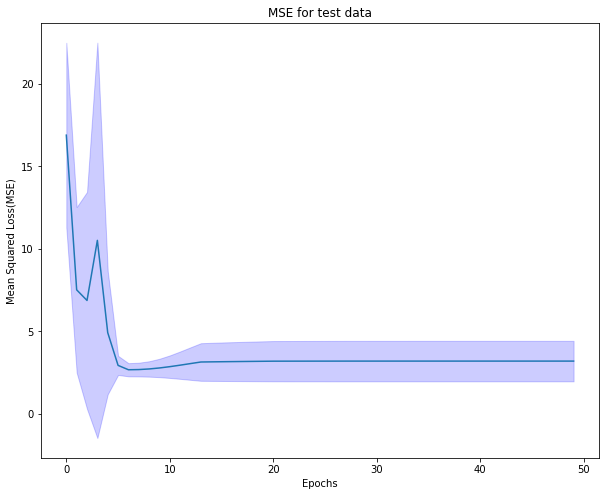

In [54]:
plt.figure(figsize=(10,8))
plt.plot(mean)

plt.fill_between(np.arange(0,50,1), ci[0], ci[1], color='blue', alpha=0.2)

plt.xlabel("Epochs")
plt.ylabel("Mean Squared Loss(MSE)")
plt.title("MSE for test data")

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SelfAttentionModel = TimeSeriesModel(18,2,5000,1)
SelfAttentionModel.to(device)
dataiter = iter(dataloaders["train"])
sample = next(dataiter)
print(sample[0].size())
SelfAttentionModel(sample[0].to(device).float())


torch.Size([3, 1000, 18])


tensor([-0.2223, -0.2197, -0.2295], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [87]:
sample[0].size()
print(model(sample[0][:,-1000:,:].to(device)))
print(sample[1])

tensor([-1628.6304,   180.3035,   180.3035], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor([3., 3., 7.])


In [40]:
split_ratio = [1/num_experiment]*num_experiment  # This is for 5-fold cross-validation
# split_ratio[-1] = 1 - sum(split_ratio[:-1])  # To ensure the ratios sum to 1
split_ratio = [int(x*len(dataset)) for x in split_ratio]

In [41]:
split_ratio[-1] = len(dataset) - sum(split_ratio[:-1])

In [42]:
split_ratio

[3, 3, 3, 3, 3, 3, 3, 3, 3, 7]

#### Cross Validation

In [27]:
num_experiment = 10
num_epochs = 50
a = np.zeros(shape=(num_experiment,num_epochs))
Bests = np.zeros(shape=(num_experiment,))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define the proportion for each split (here, 5 folds)
split_ratio = [1/num_experiment]*num_experiment  # This is for 5-fold cross-validation
# split_ratio[-1] = 1 - sum(split_ratio[:-1])  # To ensure the ratios sum to 1
split_ratio = [int(x*len(dataset)) for x in split_ratio]
split_ratio[-1] = len(dataset) - sum(split_ratio[:-1])

# Create the splits
folds = random_split(dataset, lengths=split_ratio)
dataloaders = {}
dataset_sizes ={}
# Now we can use these folds in our cross-validation
for fold in range(num_experiment):
    # Use one fold for validation and the others for training
    validation_data = folds[fold]
    training_data = torch.utils.data.ConcatDataset([folds[i] for i in range(5) if i!=fold])

    train_dataloader = DataLoader(training_data, batch_size=3)
    val_dataloader = DataLoader(validation_data, batch_size=3)
 
    dataloaders["train"] = train_dataloader
    dataset_sizes["train"] = len(training_data)
    dataloaders["test"] = val_dataloader
    dataset_sizes["test"] = len(validation_data)

    # Now, you can create your model and train it using these dataloaders, 
    # and then evaluate it on the validation dataloader.
    SelfAttentionModel = TimeSeriesModel(18,2,5000,1)
    SelfAttentionModel.to(device)
    criterion = nn.MSELoss()
    optimizer_ft = torch.optim.Adam(SelfAttentionModel.parameters(),lr=0.0003)
    # optimizer_ft =  torch.optim.SGD(SelfAttentionModel.parameters(), lr=0.003, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    constrain = WeightClipper()
    model,best_Loss,test_loss_epoch = train_model(SelfAttentionModel,criterion,exp_lr_scheduler,optimizer_ft,dataloaders,dataset_sizes,0.004,constrain,50,torch.inf)
    a[fold] = np.array(test_loss_epoch)
    Bests[fold] = best_Loss

Epoch 0/49
----------
train Loss: 26.4141
test Loss: 33.6377
Epoch 1/49
----------
train Loss: 26.3859
test Loss: 33.9996
Epoch 2/49
----------
train Loss: 26.3572
test Loss: 34.0876
Epoch 3/49
----------
train Loss: 26.3280
test Loss: 34.0836
Epoch 4/49
----------
train Loss: 26.2981
test Loss: 34.0430
Epoch 5/49
----------
train Loss: 26.2676
test Loss: 33.9864
Epoch 6/49
----------
train Loss: 26.2364
test Loss: 33.9219
Epoch 7/49
----------
train Loss: 26.2145
test Loss: 33.9167
Epoch 8/49
----------
train Loss: 26.2112
test Loss: 33.9104
Epoch 9/49
----------
train Loss: 26.2080
test Loss: 33.9036
Epoch 10/49
----------
train Loss: 26.2047
test Loss: 33.8967
Epoch 11/49
----------
train Loss: 26.2015
test Loss: 33.8897
Epoch 12/49
----------
train Loss: 26.1982
test Loss: 33.8826
Epoch 13/49
----------
train Loss: 26.1949
test Loss: 33.8756
Epoch 14/49
----------
train Loss: 26.1927
test Loss: 33.8749
Epoch 15/49
----------
train Loss: 26.1924
test Loss: 33.8742
Epoch 16/49
------

c:\Users\Mohammad\anaconda3\envs\ML\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


test Loss: 21.1770
Epoch 1/49
----------
train Loss: 29.3361
test Loss: 20.8476
Epoch 2/49
----------
train Loss: 29.2890
test Loss: 20.7209
Epoch 3/49
----------
train Loss: 29.2410
test Loss: 20.6572
Epoch 4/49
----------
train Loss: 29.1919
test Loss: 20.6143
Epoch 5/49
----------
train Loss: 29.1415
test Loss: 20.5780
Epoch 6/49
----------
train Loss: 29.0899
test Loss: 20.5433
Epoch 7/49
----------
train Loss: 29.0549
test Loss: 20.5395
Epoch 8/49
----------
train Loss: 29.0496
test Loss: 20.5359
Epoch 9/49
----------
train Loss: 29.0442
test Loss: 20.5324
Epoch 10/49
----------
train Loss: 29.0388
test Loss: 20.5289
Epoch 11/49
----------
train Loss: 29.0334
test Loss: 20.5254
Epoch 12/49
----------
train Loss: 29.0281
test Loss: 20.5219
Epoch 13/49
----------
train Loss: 29.0227
test Loss: 20.5184
Epoch 14/49
----------
train Loss: 29.0191
test Loss: 20.5181
Epoch 15/49
----------
train Loss: 29.0185
test Loss: 20.5177
Epoch 16/49
----------
train Loss: 29.0180
test Loss: 20.517

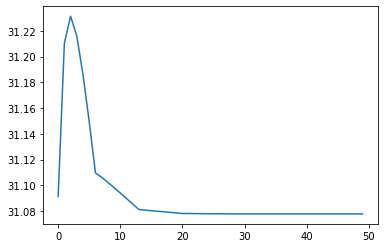

In [28]:
plt.plot(np.mean(a,axis=0))

In [38]:
Bests

array([44.01262665, 37.44750977, 34.61843109, 38.55976486, 52.48387909,
       24.87714386, 19.5505867 ,  5.52481222, 34.0345192 ,  4.86464161])

In [56]:
np.std(t['Quality score'].values[index])

1.4303313430338622